 2) Design a combinatorial bandit algorithm to optimize the budget allocation over the three subcampaigns
  to maximize the total number of clicks. Plot the cumulative regret.
prima si stimano le curve (budget allocato -> numero di click + rumore gaussiano)\n",
poi crea la tabella e si trova la combinazione migliore di sub per avere il massimo numero di click\n",


    CURVE\n",
    MAX_BUDGET * (1.0 - np.exp(-(PARAMETRO_SUB * x))\n",

    RUMORE: generazione sample con rumore\n",
    SAMPLE = np.random.normal(CLICK_Y_CURVA, VARIANZA_FISSA)\n",
    CLICK_Y_CURVA = valore del numero di click preso dalla curva dato un budget x\n",

   Dai vari SAMPLE si generano le  3 CURVA_GEN con un GP\n",

    Dalle curve si riempie la prima tabella con i valori di budget prefissati:
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    Si applica l'optimization problem per decidere la combinazione migliore di subcampaign

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner
import pandas as pd

In [2]:
n_obs = 50
x_obs = np.ndarray(shape=(0,3), dtype=float)
print(x_obs.shape)
y_obs = np.ndarray(shape=(0,3), dtype=float)
print(y_obs.shape)

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 6.0

bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = dfObj = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])


env = BiddingEnvironment(bids,max_clicks,noise_std)
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

(0, 3)
(0, 3)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
for i in range(0, n_obs):
    clicks = []
    
    #scelta dell'arm da pullare per ogni subcampaign:
    #si prende l'arm con la varianza maggiore dalla subcampaign i % 3
    #dalle altre si prende gli arm in modo casuale e facendo si che la somma si sempre il massimo
    #funziona solo con una distribuzione lineare degli arm sull'array bids
    first = i % 3
    pulled = [0,0,0]
    pulled[first] = learners[first].pull_arm()
    pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
    pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)
    
    # tabelle di click e arm pullati, da sostituire con il dataframe
    y_obs = np.append(y_obs,np.atleast_2d(clicks),0)
    x_obs = np.append(x_obs,np.atleast_2d(bids[pulled]),0)

print(y_obs.shape)
print(x_obs.shape)

(500, 3)
(500, 3)


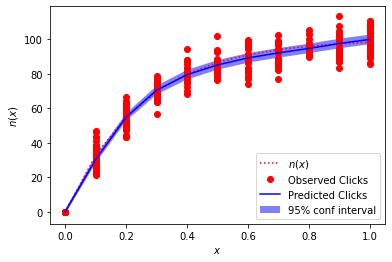

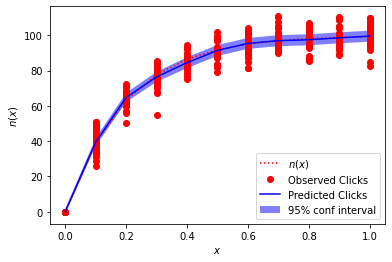

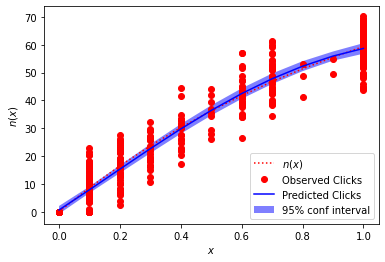

In [4]:
x_pred = np.atleast_2d(bids).T

for i in range(0,len(learners)):

    X = np.atleast_2d(x_obs[:,i]).T
    Y = y_obs[:,i].ravel()

    plt.figure()

    plt.plot(x_pred, env.subs[i](x_pred), 'r:', label=r'$n(x)$')
    plt.plot(X.ravel(), Y, 'ro', label=r'Observed Clicks')
    plt.plot(x_pred, learners[i].means, 'b-', label=r'Predicted Clicks')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([learners[i].means - 1.96 * learners[i].sigmas, (learners[i].means + 1.96 * learners[i].sigmas)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% conf interval')
    plt.xlabel('$x$')
    plt.ylabel('$n(x)$')
    plt.legend(loc='lower right')
    plt.show()

Ora va sviluppato l'algoritmo della tabella
per prendera l'alloacazione migliore

budget1 + budget2 + budget3 = 1

In [5]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)

[[ 0.2872763  30.42327908 54.87890708 70.45712984 79.3907464  85.05328155
  89.10093736 92.02845484 94.58204541 97.42868702 99.80723913]
 [ 0.19804035 39.51348457 64.78617984 76.43649226 84.49930207 91.39849305
  95.40512246 96.94100023 97.47768283 98.54221795 99.51180197]
 [ 0.62609107  7.88624244 15.29897988 22.65280263 29.74597227 36.39556675
  42.44489858 47.76891521 52.27739403 55.91593675 58.66493797]]


ALGORITMO DELLA TABELLA:

In [6]:
algorithm_table = np.ndarray(shape=(0,len(bids)), dtype=float)

for l in learners:
   algorithm_table = np.append(algorithm_table,np.atleast_2d(np.zeros(len(bids))),0)

algorithm_table[0,:] = table_all_Subs[0,:]

allocations_table = [[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]]


for i in range(1, n_subcamp):
    allocations_table.append([[],[],[],[],[],[],[],[],[],[],[]])

    for j in range(0, len(bids)):
        possibilities = np.array([])
        poss_allocation = []
        for p in range(0,j+1):
            #if bids[p] + bids[j-p] <= bids[j] :
            possibilities = np.append(possibilities, table_all_Subs[i,p]+algorithm_table[i-1,j-p])
            poss_allocation.append(allocations_table[i-1][j-p] + [p])
            #print(str(i)+" "+ str(p) + " "+ str(j-p))

        max_index = np.argmax(possibilities)
        #print(poss_allocation)
        #print(possibilities)

        #print(max_index)
        algorithm_table[i,j] = possibilities[max_index]
        allocations_table[i][j] = poss_allocation[max_index]





In [7]:
print(allocations_table[n_subcamp-1])
print(max(algorithm_table[n_subcamp-1]))
print(total_click_each_day)


[[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 2, 0], [2, 2, 0], [3, 2, 0], [3, 3, 0], [4, 3, 0], [4, 4, 0], [4, 4, 1], [4, 4, 2]]
179.18902835274662
     bid_sub1  bid_sub2  bid_sub3     click1      click2     click3
0         0.0      10.0       0.0   0.000000   95.518939   0.000000
1         4.0       0.0       6.0  77.230088    0.000000  37.456878
2         0.0       9.0       1.0   0.000000   89.669764   3.792968
3         1.0       5.0       4.0  22.178683   89.906659  20.495331
4         8.0       2.0       0.0  92.308893   60.226637   0.000000
..        ...       ...       ...        ...         ...        ...
495       9.0       1.0       0.0  91.643373   39.064723   0.000000
496       0.0       8.0       2.0   0.000000  101.777129  22.486821
497       0.0       0.0      10.0   0.000000    0.000000  61.062225
498       7.0       1.0       2.0  97.025245   41.590485  17.063670
499       3.0       6.0       1.0  63.958556   88.924631   5.134241

[500 rows x 6 columns]
